[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PTB-MR/mrpro/blob/main/examples/notebooks/direct_reconstruction.ipynb) [![Download notebook](https://img.shields.io/badge/Download-notebook-blue?logo=jupyter)](path:direct_reconstruction.ipynb)

In [1]:
import importlib

if not importlib.util.find_spec('mrpro'):
    %pip install mrpro[notebook]

# Direct Reconstruction of 2D golden angle radial data
Here we use the DirectReconstruction class to reconstruct images from ISMRMRD 2D radial data

In [2]:
# define zenodo URL of the example ismrmd data
zenodo_url = 'https://zenodo.org/records/10854057/files/'
fname = 'pulseq_radial_2D_402spokes_golden_angle_with_traj.h5'

In [3]:
# Download raw data
import tempfile

import requests

data_file = tempfile.NamedTemporaryFile(mode='wb', delete=False, suffix='.h5')
response = requests.get(zenodo_url + fname, timeout=30)
data_file.write(response.content)
data_file.flush()

### Image reconstruction
We use the DirectReconstruction class to reconstruct images from 2D radial data.
DirectReconstruction estimates CSMs, DCFs and performs an adjoint Fourier transform.
This is a high-level interface to the reconstruction pipeline.

In [4]:
import mrpro

# Use the trajectory that is stored in the ISMRMRD file
trajectory = mrpro.data.traj_calculators.KTrajectoryIsmrmrd()
# Load in the Data from the ISMRMRD file
kdata = mrpro.data.KData.from_file(data_file.name, trajectory)
# Perform the reconstruction
reconstruction = mrpro.algorithms.reconstruction.DirectReconstruction(kdata)
# Use this to run on gpu: kdata = kdata.cuda()
img = reconstruction(kdata)

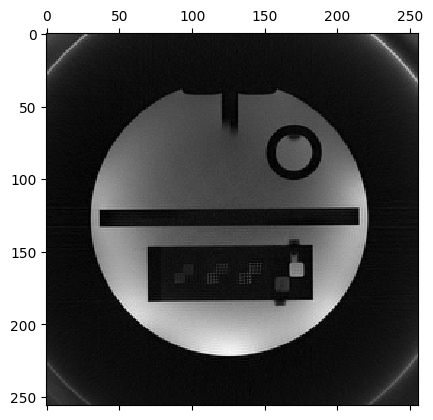

In [5]:
import matplotlib.pyplot as plt

# Display the reconstructed image
# If there are multiple slices, ..., only the first one is selected
first_img = img.rss().cpu()[0, 0, :, :]  #  images, z, y, x
plt.matshow(first_img, cmap='gray')

### Behind the scenes
These steps are done in a direct reconstruction:

In [6]:
# Calculate dcf using the trajectory
dcf_operator = mrpro.data.DcfData.from_traj_voronoi(kdata.traj).as_operator()

# Define Fourier operator using the trajectory
# and header information in kdata
fourier_operator = dcf_operator @ mrpro.operators.FourierOp.from_kdata(kdata)
adjoint_operator = fourier_operator.H

# Calculate coil maps
# Note that operators return a tuple of tensors, so we need to unpack it,
# even though there is only one tensor returned from adjoint operator.
img_coilwise = mrpro.data.IData.from_tensor_and_kheader(*adjoint_operator(kdata.data), kdata.header)
csm_operator = mrpro.data.CsmData.from_idata_walsh(img_coilwise).as_operator()

# Perform Direct Reconstruction
forward_operator = fourier_operator @ csm_operator
adjoint_operator = forward_operator.H
img_manual = mrpro.data.IData.from_tensor_and_kheader(*adjoint_operator(kdata.data), kdata.header)

### Further behind the scenes
... these steps are equivalent to:

In [7]:
# Define Fourier operator
fourier_operator = mrpro.operators.FourierOp(
    recon_matrix=kdata.header.recon_matrix,
    encoding_matrix=kdata.header.encoding_matrix,
    traj=kdata.traj,
)

# Calculate dcf using the trajectory
dcf_data = mrpro.data.DcfData.from_traj_voronoi(kdata.traj)

# Perform adjoint Fourier transform
# Note that operators return a tuple of tensors, so we need to unpack it.
(img_tensor_coilwise,) = fourier_operator.adjoint(kdata.data * dcf_data.data.unsqueeze(-4))
img_coilwise = mrpro.data.IData.from_tensor_and_kheader(img_tensor_coilwise, kdata.header)


# Calculate and apply coil maps
csm_data = mrpro.data.CsmData.from_idata_walsh(img_coilwise)
csm_operator = mrpro.operators.SensitivityOp(csm_data)
(img_tensor_coilcombined,) = csm_operator.adjoint(img_tensor_coilwise)

img_more_manual = mrpro.data.IData.from_tensor_and_kheader(img_tensor_coilcombined, kdata.header)

### Check for equal results
The 3 versions result should in the same image data.

In [8]:
import torch

# If the assert statement did not raise an exception, the results are equal.
assert torch.allclose(img.data, img_manual.data)
assert torch.allclose(img.data, img_more_manual.data)